# Estimate polarization from raytracing and compare to reco pol

#### Reco pol is now done by using the same window for both hpol and vpol

### Feb 23, 2021

## Code

In [24]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
# import ROOT
import math
import numpy as np
# from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
# from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
# import deDisperse_util as util
# from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
# import pyrex.custom.ara as ara


In [25]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")

In [26]:
def rotation_matrix_from_vectors(vec1, vec2):
    """ Find the rotation matrix that aligns vec1 to vec2
    :param vec1: A 3d "source" vector
    :param vec2: A 3d "destination" vector
    :return mat: A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def rotatePolVector(launchVecSrc, recVec, PolVecAntenna):
    recVec = -recVec #receiving vector needs to be reflected, otherwise rotation matrix will be off by pi
    newPol = np.dot(PolVecAntenna,rotation_matrix_from_vectors(launchVecSrc,recVec))
    return newPol

def Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])

#### From Dave Besson, the cross pol is of about 25%, and it's due to the transmitter beam pattern.

## Expected polarization 

In [27]:
def estimatePolRayTracer(depth):
    #Take depth of pulser and calculate polarization rotation based on raytracer results.
    rt = pyrex.RayTracer(from_point=(0, 0, -depth), to_point=(2400, 0, -179.93)) #Use the depth of the transmitter as the z-
    #coordinate. A2 is at a horizontal distance of 2400 m from the pulser, and at a depth of 179.93 m
    path = rt.solutions[0] #We only care about direct solutions
    rotMat = rotation_matrix_from_vectors(path.received_direction,path.emitted_direction)
    initPulserPol = np.array([0,0,1])
#     initPulserPol = np.array([np.sqrt(0.25/2),np.sqrt(0.25/2),np.sqrt(0.75)])
    rotAngle = np.pi/2-np.arccos(path.emitted_direction[2])
#     pulserPol = np.array(np.matmul(initPulserPol,Rx(rotAngle)))[0]
    rotatedPol = np.dot(initPulserPol,rotMat)
    newOmegaPol = np.degrees(np.arccos(rotatedPol[2]))
    return newOmegaPol-np.degrees(rotAngle)

# Compare to real data

In [95]:
SpiceCore0 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh0_8_run_012577_30PercentCrossPol.pkl")
SpiceCore0 = SpiceCore0.loc[SpiceCore0.theta_reco>=90]

SpiceCore1 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh1_9_run_012577_30PercentCrossPol.pkl")
SpiceCore1 = SpiceCore1.loc[SpiceCore1.theta_reco>=90]

SpiceCore2 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh2_10_run_012577_30PercentCrossPol.pkl")
SpiceCore2 = SpiceCore2.loc[SpiceCore2.theta_reco>=90]

SpiceCore3 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh3_11_run_012577_30PercentCrossPol.pkl")
SpiceCore3 = SpiceCore3.loc[SpiceCore3.theta_reco>=90]

SpiceCore4 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh4_12_run_012577_30PercentCrossPol.pkl")
SpiceCore4 = SpiceCore4.loc[SpiceCore4.theta_reco>=90]

SpiceCore5 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh5_13_run_012577_30PercentCrossPol.pkl")
SpiceCore5 = SpiceCore5.loc[SpiceCore5.theta_reco>=90]

SpiceCore6 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh6_14_run_012577_30PercentCrossPol.pkl")
SpiceCore6 = SpiceCore6.loc[SpiceCore6.theta_reco>=90]

In [96]:
depth_1226 = pd.read_csv("./plots/SpiceCorePolReco/A2_1226Depth.txt")
time = pd.to_datetime(depth_1226.NZ_Time)
# time = time.reindex(time)
# time = time.tz_localize('NZ').tz_convert("UTC")
time.head()
newTime = time.apply(lambda dt: dt.replace(day=26, month = 12, year = 2018))
# newTime#Still in NZ local time. Need to translate to UTC
df = pd.DataFrame(1, index=newTime, columns=['X'])
import pytz
nz = pytz.timezone('NZ')
utc = pytz.timezone('UTC')
df.index = df.index.tz_localize(nz).tz_convert(utc)
unixTimeDepth = (df.index - pd.Timestamp("1970-01-01").tz_localize(utc)) // pd.Timedelta('1s')#This is unix time 

In [97]:
f = scipy.interpolate.interp1d(unixTimeDepth, depth_1226.depth,bounds_error=False, fill_value=0.)
SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

In [98]:
SpiceCore0ForInterp = SpiceCore0.loc[(SpiceCore0.unixtime>min(SpiceCore0.unixtime)) & (SpiceCore0.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore0ForInterp.unixtime)
SpiceCore0ForInterp["interp_depth"] = interp_depth

SpiceCore1ForInterp = SpiceCore1.loc[(SpiceCore1.unixtime>min(SpiceCore1.unixtime)) & (SpiceCore1.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore1ForInterp.unixtime)
SpiceCore1ForInterp["interp_depth"] = interp_depth

SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

SpiceCore3ForInterp = SpiceCore3.loc[(SpiceCore3.unixtime>min(SpiceCore3.unixtime)) & (SpiceCore3.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore3ForInterp.unixtime)
SpiceCore3ForInterp["interp_depth"] = interp_depth

SpiceCore4ForInterp = SpiceCore4.loc[(SpiceCore4.unixtime>min(SpiceCore4.unixtime)) & (SpiceCore4.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore4ForInterp.unixtime)
SpiceCore4ForInterp["interp_depth"] = interp_depth

SpiceCore5ForInterp = SpiceCore5.loc[(SpiceCore5.unixtime>min(SpiceCore5.unixtime)) & (SpiceCore5.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore5ForInterp.unixtime)
SpiceCore5ForInterp["interp_depth"] = interp_depth

SpiceCore6ForInterp = SpiceCore6.loc[(SpiceCore6.unixtime>min(SpiceCore6.unixtime)) & (SpiceCore6.unixtime<3.5*1E3+1.54579*1E9)]
interp_depth = f(SpiceCore6ForInterp.unixtime)
SpiceCore6ForInterp["interp_depth"] = interp_depth

In [99]:
# SpiceCore0ForInterp_limited = 0
SpiceCore0ForInterp_limited = SpiceCore0ForInterp.loc[(SpiceCore0ForInterp.interp_depth>600) & (SpiceCore0ForInterp.interp_depth<1000)]
# SpiceCore0ForInterp_limited = SpiceCore0ForInterp.loc[(SpiceCore0ForInterp.interp_depth>600)]
# SpiceCore1ForInterp_limited = SpiceCore1ForInterp.loc[(SpiceCore1ForInterp.interp_depth>600) & (SpiceCore1ForInterp.interp_depth<1000)]
# SpiceCore2ForInterp_limited = SpiceCore2ForInterp.loc[(SpiceCore2ForInterp.interp_depth>600) & (SpiceCore2ForInterp.interp_depth<1000)]
# SpiceCore3ForInterp_limited = SpiceCore3ForInterp.loc[(SpiceCore3ForInterp.interp_depth>600) & (SpiceCore3ForInterp.interp_depth<1000)]
SpiceCore4ForInterp_limited = SpiceCore4ForInterp.loc[(SpiceCore4ForInterp.interp_depth>600) & (SpiceCore4ForInterp.interp_depth<1000)]
# SpiceCore5ForInterp_limited = SpiceCore5ForInterp.loc[(SpiceCore5ForInterp.interp_depth>600) & (SpiceCore5ForInterp.interp_depth<1000)]
# SpiceCore6ForInterp_limited = SpiceCore6ForInterp.loc[(SpiceCore6ForInterp.interp_depth>600) & (SpiceCore6ForInterp.interp_depth<1000)]


In [100]:

depthArr0 = []
pol0 = []

depthArr1 = []
pol1 = []

for i in SpiceCore0ForInterp_limited.itertuples():
    depthArr0.append(i.interp_depth)
    pol0.append(abs(estimatePolRayTracer(i.interp_depth)))
    
for i in SpiceCore4ForInterp_limited.itertuples():
    depthArr1.append(i.interp_depth)
    pol1.append(abs(estimatePolRayTracer(i.interp_depth)))

In [101]:
SpiceCore0ForInterp_limited["Omega_true"] = pol0
SpiceCore4ForInterp_limited["Omega_true"] = pol1

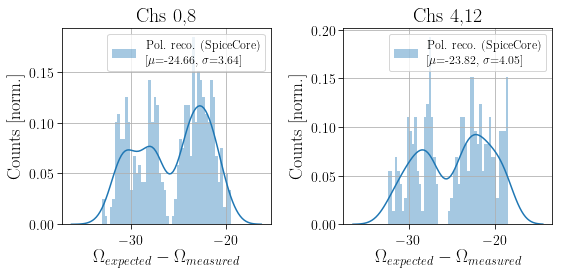

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
axs = ax.ravel()
delta = SpiceCore0ForInterp_limited.Omega_true-SpiceCore0ForInterp_limited.Omega_reco
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "Pol. reco. (SpiceCore)\n [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[0]);
axs[0].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[0].set_ylabel("Counts [norm.]")
axs[0].legend()
axs[0].grid()
axs[0].title.set_text("Chs 0,8")
# plt.title("$\Delta\Omega$ for SpiceCore events using a single channel pair")

delta = SpiceCore4ForInterp_limited.Omega_true-SpiceCore4ForInterp_limited.Omega_reco
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "Pol. reco. (SpiceCore)\n [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[1]);
axs[1].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[1].set_ylabel("Counts [norm.]")
axs[1].legend()
axs[1].grid()
axs[1].title.set_text("Chs 4,12")
plt.tight_layout()
# plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaDist_un012577.png', dpi=250)

In [103]:
SNR_arr = []
meanV = []
sigmaV = []

for SNR in np.arange(10,81,1):
    SNR_SpiceCore0ForInterp_limited = SpiceCore0ForInterp_limited.loc[abs(SpiceCore0ForInterp_limited.SNR_V-SNR)<=1]
    SNR_arr.append(SNR)
    delta = SNR_SpiceCore0ForInterp_limited.Omega_true-SNR_SpiceCore0ForInterp_limited.Omega_reco
    #Omega
    mean = delta.median()
    sigma = delta.std()
#     print(mean)
    meanV.append(mean)
    sigmaV.append(sigma)

meanV = np.array(meanV)
sigmaV = np.array(sigmaV)

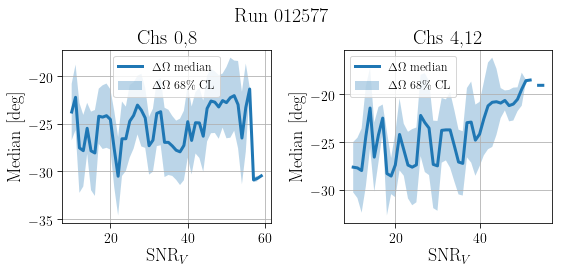

In [104]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
axs = ax.ravel()

SNR_arr = []
meanV = []
sigmaV = []

for SNR in np.arange(10,81,1):
    SNR_SpiceCore0ForInterp_limited = SpiceCore0ForInterp_limited.loc[abs(SpiceCore0ForInterp_limited.SNR_V-SNR)<=1]
    SNR_arr.append(SNR)
    delta = SNR_SpiceCore0ForInterp_limited.Omega_true-SNR_SpiceCore0ForInterp_limited.Omega_reco
    #Omega
    mean = delta.median()
    sigma = delta.std()
#     print(mean)
    meanV.append(mean)
    sigmaV.append(sigma)

meanV = np.array(meanV)
sigmaV = np.array(sigmaV)

axs[0].plot(SNR_arr,meanV, lw = 3,label="$\Delta \Omega$ median")
axs[0].fill_between(SNR_arr,meanV-sigmaV,meanV+sigmaV, alpha = 0.3, label="$\Delta \Omega$ 68\% CL")
axs[0].set_xlabel("SNR$_{V}$")
axs[0].set_ylabel("Median [deg]")
axs[0].grid()
axs[0].legend()
axs[0].title.set_text("Chs 0,8")

SNR_arr = []
meanV = []
sigmaV = []

for SNR in np.arange(10,81,1):
    SNR_SpiceCore4ForInterp_limited = SpiceCore4ForInterp_limited.loc[abs(SpiceCore4ForInterp_limited.SNR_V-SNR)<=1]
    SNR_arr.append(SNR)
    delta = SNR_SpiceCore4ForInterp_limited.Omega_true-SNR_SpiceCore4ForInterp_limited.Omega_reco
    #Omega
    mean = delta.median()
    sigma = delta.std()
#     print(mean)
    meanV.append(mean)
    sigmaV.append(sigma)

meanV = np.array(meanV)
sigmaV = np.array(sigmaV)

axs[1].plot(SNR_arr,meanV, lw = 3,label="$\Delta \Omega$ median")
axs[1].fill_between(SNR_arr,meanV-sigmaV,meanV+sigmaV, alpha = 0.3, label="$\Delta \Omega$ 68\% CL")
axs[1].set_xlabel("SNR$_{V}$")
axs[1].set_ylabel("Median [deg]")
axs[1].grid()
axs[1].legend()
axs[1].title.set_text("Chs 4,12")
plt.suptitle("Run 012577",fontsize = 20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# axs[0].title("$\Delta\Omega$ for SpiceCore events using a single channel pair")
# plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaOmegaVsSNR_run012577.png', dpi=250)

# Dec 24

In [38]:
SpiceCore0 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh0_8_run_012559_softTrigPow.pkl")
SpiceCore0 = SpiceCore0.loc[SpiceCore0.theta_reco>=90]

SpiceCore1 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh1_9_run_012559_softTrigPow.pkl")
SpiceCore1 = SpiceCore1.loc[SpiceCore1.theta_reco>=90]

SpiceCore2 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh2_10_run_012559_softTrigPow.pkl")
SpiceCore2 = SpiceCore2.loc[SpiceCore2.theta_reco>=90]

SpiceCore3 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh3_11_run_012559_softTrigPow.pkl")
SpiceCore3 = SpiceCore3.loc[SpiceCore3.theta_reco>=90]

SpiceCore4 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh4_12_run_012559_softTrigPow.pkl")
SpiceCore4 = SpiceCore4.loc[SpiceCore4.theta_reco>=90]

SpiceCore5 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh5_13_run_012559_softTrigPow.pkl")
SpiceCore5 = SpiceCore5.loc[SpiceCore5.theta_reco>=90]

SpiceCore6 = pd.read_pickle("../ARA_analysis/ARA_Reconstruction/RecoOmegaCh6_14_run_012559_softTrigPow.pkl")
SpiceCore6 = SpiceCore6.loc[SpiceCore6.theta_reco>=90]

In [39]:
depth_1224 = pd.read_csv("./plots/SpiceCorePolReco/A2_1224Depth.txt")
time = pd.to_datetime(depth_1224.NZ_Time)
# time = time.reindex(time)
# time = time.tz_localize('NZ').tz_convert("UTC")
time.head()
newTime = time.apply(lambda dt: dt.replace(day=24, month = 12, year = 2018))
# newTime#Still in NZ local time. Need to translate to UTC
df = pd.DataFrame(1, index=newTime, columns=['X'])
import pytz
nz = pytz.timezone('NZ')
utc = pytz.timezone('UTC')
df.index = df.index.tz_localize(nz).tz_convert(utc)
unixTimeDepth = (df.index - pd.Timestamp("1970-01-01").tz_localize(utc)) // pd.Timedelta('1s')#This is unix time 

In [40]:
f = scipy.interpolate.interp1d(unixTimeDepth, depth_1224.depth,bounds_error=False, fill_value=0.)
SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

In [41]:
SpiceCore0ForInterp = SpiceCore0.loc[(SpiceCore0.unixtime>min(SpiceCore0.unixtime)) & (SpiceCore0.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore0ForInterp.unixtime)
SpiceCore0ForInterp["interp_depth"] = interp_depth

SpiceCore1ForInterp = SpiceCore1.loc[(SpiceCore1.unixtime>min(SpiceCore1.unixtime)) & (SpiceCore1.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore1ForInterp.unixtime)
SpiceCore1ForInterp["interp_depth"] = interp_depth

SpiceCore2ForInterp = SpiceCore2.loc[(SpiceCore2.unixtime>min(SpiceCore2.unixtime)) & (SpiceCore2.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore2ForInterp.unixtime)
SpiceCore2ForInterp["interp_depth"] = interp_depth

SpiceCore3ForInterp = SpiceCore3.loc[(SpiceCore3.unixtime>min(SpiceCore3.unixtime)) & (SpiceCore3.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore3ForInterp.unixtime)
SpiceCore3ForInterp["interp_depth"] = interp_depth

SpiceCore4ForInterp = SpiceCore4.loc[(SpiceCore4.unixtime>min(SpiceCore4.unixtime)) & (SpiceCore4.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore4ForInterp.unixtime)
SpiceCore4ForInterp["interp_depth"] = interp_depth

SpiceCore5ForInterp = SpiceCore5.loc[(SpiceCore5.unixtime>min(SpiceCore5.unixtime)) & (SpiceCore5.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore5ForInterp.unixtime)
SpiceCore5ForInterp["interp_depth"] = interp_depth

SpiceCore6ForInterp = SpiceCore6.loc[(SpiceCore6.unixtime>min(SpiceCore6.unixtime)) & (SpiceCore6.unixtime<2.15*1E4+1.5456*1E9)]
interp_depth = f(SpiceCore6ForInterp.unixtime)
SpiceCore6ForInterp["interp_depth"] = interp_depth

In [42]:
# SpiceCore0ForInterp_limited = 0
SpiceCore0ForInterp_limited = SpiceCore0ForInterp.loc[(SpiceCore0ForInterp.interp_depth>600) & (SpiceCore0ForInterp.interp_depth<1000)]
SpiceCore1ForInterp_limited = SpiceCore1ForInterp.loc[(SpiceCore1ForInterp.interp_depth>600) & (SpiceCore1ForInterp.interp_depth<1000)]
SpiceCore2ForInterp_limited = SpiceCore2ForInterp.loc[(SpiceCore2ForInterp.interp_depth>600) & (SpiceCore2ForInterp.interp_depth<1000)]
SpiceCore3ForInterp_limited = SpiceCore3ForInterp.loc[(SpiceCore3ForInterp.interp_depth>600) & (SpiceCore3ForInterp.interp_depth<1000)]
SpiceCore4ForInterp_limited = SpiceCore4ForInterp.loc[(SpiceCore4ForInterp.interp_depth>600) & (SpiceCore4ForInterp.interp_depth<1000)]
SpiceCore5ForInterp_limited = SpiceCore5ForInterp.loc[(SpiceCore5ForInterp.interp_depth>600) & (SpiceCore5ForInterp.interp_depth<1000)]
SpiceCore6ForInterp_limited = SpiceCore6ForInterp.loc[(SpiceCore6ForInterp.interp_depth>600) & (SpiceCore6ForInterp.interp_depth<1000)]


In [43]:

depthArr0 = []
pol0 = []

depthArr1 = []
pol1 = []

depthArr2 = []
pol2 = []

depthArr3 = []
pol3 = []

depthArr4 = []
pol4 = []

depthArr5 = []
pol5 = []

depthArr6 = []
pol6 = []

for i in SpiceCore0ForInterp_limited.itertuples():
    depthArr0.append(i.interp_depth)
    pol0.append(abs(estimatePolRayTracer(i.interp_depth)))
    
for i in SpiceCore1ForInterp_limited.itertuples():
    depthArr1.append(i.interp_depth)
    pol1.append(abs(estimatePolRayTracer(i.interp_depth)))
    
for i in SpiceCore2ForInterp_limited.itertuples():
    depthArr2.append(i.interp_depth)
    pol2.append(abs(estimatePolRayTracer(i.interp_depth)))
    
for i in SpiceCore3ForInterp_limited.itertuples():
    depthArr3.append(i.interp_depth)
    pol3.append(abs(estimatePolRayTracer(i.interp_depth)))
    
for i in SpiceCore4ForInterp_limited.itertuples():
    depthArr4.append(i.interp_depth)
    pol4.append(abs(estimatePolRayTracer(i.interp_depth)))
    
for i in SpiceCore5ForInterp_limited.itertuples():
    depthArr5.append(i.interp_depth)
    pol5.append(abs(estimatePolRayTracer(i.interp_depth)))
    
for i in SpiceCore6ForInterp_limited.itertuples():
    depthArr6.append(i.interp_depth)
    pol6.append(abs(estimatePolRayTracer(i.interp_depth)))

In [44]:

SpiceCore0ForInterp_limited["Omega_true"] = pol0
SpiceCore1ForInterp_limited["Omega_true"] = pol1
SpiceCore2ForInterp_limited["Omega_true"] = pol2
SpiceCore3ForInterp_limited["Omega_true"] = pol3
SpiceCore4ForInterp_limited["Omega_true"] = pol4
SpiceCore5ForInterp_limited["Omega_true"] = pol5
SpiceCore6ForInterp_limited["Omega_true"] = pol6


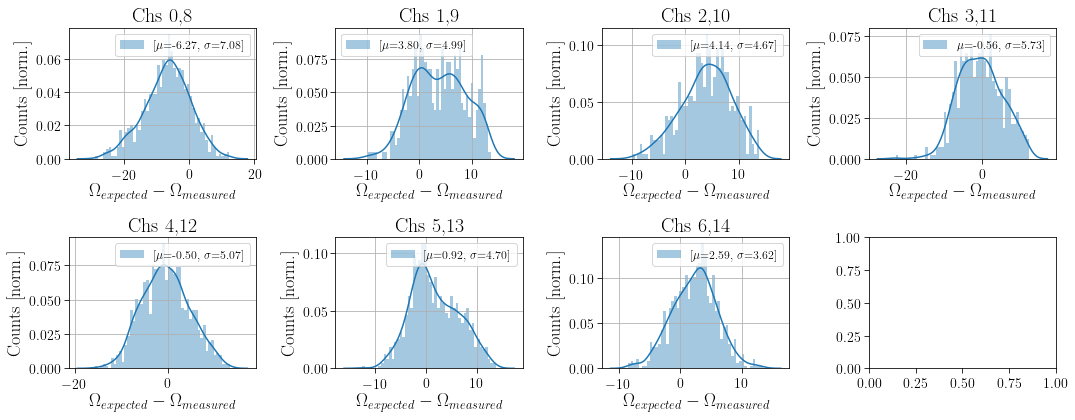

In [21]:
fig, ax = plt.subplots(2, 4, figsize=(15,6))
axs = ax.ravel()
delta = SpiceCore0ForInterp_limited.Omega_true-SpiceCore0ForInterp_limited.Omega_reco
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[0]);
axs[0].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[0].set_ylabel("Counts [norm.]")
axs[0].legend()
axs[0].grid()
axs[0].title.set_text("Chs 0,8")
# plt.title("$\Delta\Omega$ for SpiceCore events using a single channel pair")

delta = SpiceCore1ForInterp_limited.Omega_true-SpiceCore1ForInterp_limited.Omega_reco
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[1]);
axs[1].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[1].set_ylabel("Counts [norm.]")
axs[1].legend()
axs[1].grid()
axs[1].title.set_text("Chs 1,9")

delta = SpiceCore2ForInterp_limited.Omega_true-SpiceCore2ForInterp_limited.Omega_reco
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[2]);
axs[2].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[2].set_ylabel("Counts [norm.]")
axs[2].legend()
axs[2].grid()
axs[2].title.set_text("Chs 2,10")

delta = SpiceCore3ForInterp_limited.Omega_true-SpiceCore3ForInterp_limited.Omega_reco
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[3]);
axs[3].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[3].set_ylabel("Counts [norm.]")
axs[3].legend()
axs[3].grid()
axs[3].title.set_text("Chs 3,11")

delta = SpiceCore4ForInterp_limited.Omega_true-SpiceCore4ForInterp_limited.Omega_reco
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[4]);
axs[4].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[4].set_ylabel("Counts [norm.]")
axs[4].legend()
axs[4].grid()
axs[4].title.set_text("Chs 4,12")

delta = SpiceCore5ForInterp_limited.Omega_true-SpiceCore5ForInterp_limited.Omega_reco
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[5]);
axs[5].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[5].set_ylabel("Counts [norm.]")
axs[5].legend()
axs[5].grid()
axs[5].title.set_text("Chs 5,13")

delta = SpiceCore6ForInterp_limited.Omega_true-SpiceCore6ForInterp_limited.Omega_reco
delta_mean= np.median(delta)
variance = delta.std()

sns.distplot(delta, bins = 50,label = "[$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean,variance), ax =axs[6]);
axs[6].set_xlabel("$\\Omega_{expected}-\\Omega_{measured}$")
axs[6].set_ylabel("Counts [norm.]")
axs[6].legend()
axs[6].grid()
axs[6].title.set_text("Chs 6,14")

plt.tight_layout()
plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaDist_run012559.png', dpi=250)

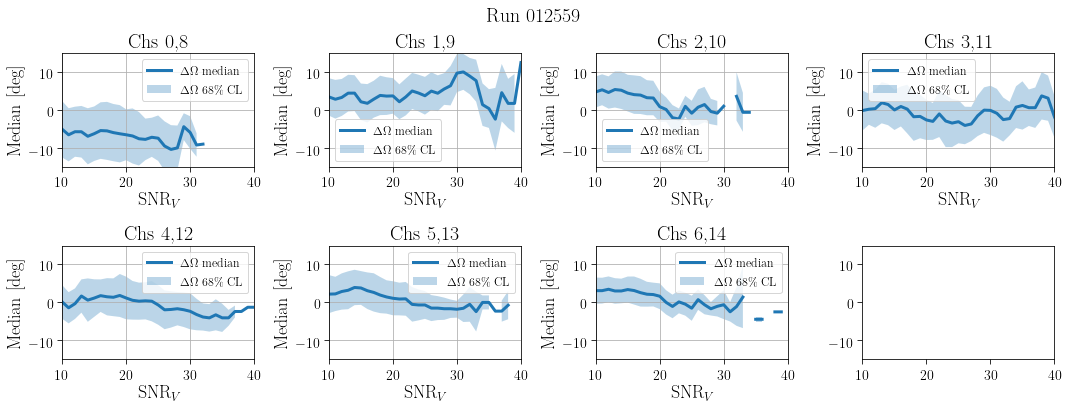

In [76]:
fig, ax = plt.subplots(2, 4, figsize=(15,6))
axs = ax.ravel()

SNR_arr = []
meanV = []
sigmaV = []

for SNR in np.arange(10,81,1):
    SNR_SpiceCore0ForInterp_limited = SpiceCore0ForInterp_limited.loc[abs(SpiceCore0ForInterp_limited.SNR_V-SNR)<=1]
    SNR_arr.append(SNR)
    delta = SNR_SpiceCore0ForInterp_limited.Omega_true-SNR_SpiceCore0ForInterp_limited.Omega_reco
    #Omega
    mean = delta.median()
    sigma = delta.std()
#     print(mean)
    meanV.append(mean)
    sigmaV.append(sigma)

meanV = np.array(meanV)
sigmaV = np.array(sigmaV)

axs[0].plot(SNR_arr,meanV, lw = 3,label="$\Delta \Omega$ median")
axs[0].fill_between(SNR_arr,meanV-sigmaV,meanV+sigmaV, alpha = 0.3, label="$\Delta \Omega$ 68\% CL")
axs[0].set_xlabel("SNR$_{V}$")
axs[0].set_ylabel("Median [deg]")
axs[0].grid()
axs[0].legend()
axs[0].title.set_text("Chs 0,8")

SNR_arr = []
meanV = []
sigmaV = []

for SNR in np.arange(10,81,1):
    SNR_SpiceCore1ForInterp_limited = SpiceCore1ForInterp_limited.loc[abs(SpiceCore1ForInterp_limited.SNR_V-SNR)<=1]
    SNR_arr.append(SNR)
    delta = SNR_SpiceCore1ForInterp_limited.Omega_true-SNR_SpiceCore1ForInterp_limited.Omega_reco
    #Omega
    mean = delta.median()
    sigma = delta.std()
#     print(mean)
    meanV.append(mean)
    sigmaV.append(sigma)

meanV = np.array(meanV)
sigmaV = np.array(sigmaV)

axs[1].plot(SNR_arr,meanV, lw = 3,label="$\Delta \Omega$ median")
axs[1].fill_between(SNR_arr,meanV-sigmaV,meanV+sigmaV, alpha = 0.3, label="$\Delta \Omega$ 68\% CL")
axs[1].set_xlabel("SNR$_{V}$")
axs[1].set_ylabel("Median [deg]")
axs[1].grid()
axs[1].legend()
axs[1].title.set_text("Chs 1,9")

plt.tight_layout()


SNR_arr = []
meanV = []
sigmaV = []

for SNR in np.arange(10,81,1):
    SNR_SpiceCore2ForInterp_limited = SpiceCore2ForInterp_limited.loc[abs(SpiceCore2ForInterp_limited.SNR_V-SNR)<=1]
    SNR_arr.append(SNR)
    delta = SNR_SpiceCore2ForInterp_limited.Omega_true-SNR_SpiceCore2ForInterp_limited.Omega_reco
    #Omega
    mean = delta.median()
    sigma = delta.std()
#     print(mean)
    meanV.append(mean)
    sigmaV.append(sigma)

meanV = np.array(meanV)
sigmaV = np.array(sigmaV)

axs[2].plot(SNR_arr,meanV, lw = 3,label="$\Delta \Omega$ median")
axs[2].fill_between(SNR_arr,meanV-sigmaV,meanV+sigmaV, alpha = 0.3, label="$\Delta \Omega$ 68\% CL")
axs[2].set_xlabel("SNR$_{V}$")
axs[2].set_ylabel("Median [deg]")
axs[2].grid()
axs[2].legend()
axs[2].title.set_text("Chs 2,10")
# axs[0].title("$\Delta\Omega$ for SpiceCore events using a single channel pair")
# plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaOmegaVsSNR_preliminary.png', dpi=250)

SNR_arr = []
meanV = []
sigmaV = []

for SNR in np.arange(10,81,1):
    SNR_SpiceCore3ForInterp_limited = SpiceCore3ForInterp_limited.loc[abs(SpiceCore3ForInterp_limited.SNR_V-SNR)<=1]
    SNR_arr.append(SNR)
    delta = SNR_SpiceCore3ForInterp_limited.Omega_true-SNR_SpiceCore3ForInterp_limited.Omega_reco
    #Omega
    mean = delta.median()
    sigma = delta.std()
#     print(mean)
    meanV.append(mean)
    sigmaV.append(sigma)

meanV = np.array(meanV)
sigmaV = np.array(sigmaV)

axs[3].plot(SNR_arr,meanV, lw = 3,label="$\Delta \Omega$ median")
axs[3].fill_between(SNR_arr,meanV-sigmaV,meanV+sigmaV, alpha = 0.3, label="$\Delta \Omega$ 68\% CL")
axs[3].set_xlabel("SNR$_{V}$")
axs[3].set_ylabel("Median [deg]")
axs[3].grid()
axs[3].legend()
axs[3].title.set_text("Chs 3,11")
# axs[0].title("$\Delta\Omega$ for SpiceCore events using a single channel pair")
# plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaOmegaVsSNR_preliminary.png', dpi=250)


SNR_arr = []
meanV = []
sigmaV = []

for SNR in np.arange(10,81,1):
    SNR_SpiceCore4ForInterp_limited = SpiceCore4ForInterp_limited.loc[abs(SpiceCore4ForInterp_limited.SNR_V-SNR)<=1]
    SNR_arr.append(SNR)
    delta = SNR_SpiceCore4ForInterp_limited.Omega_true-SNR_SpiceCore4ForInterp_limited.Omega_reco
    #Omega
    mean = delta.median()
    sigma = delta.std()
#     print(mean)
    meanV.append(mean)
    sigmaV.append(sigma)

meanV = np.array(meanV)
sigmaV = np.array(sigmaV)

axs[4].plot(SNR_arr,meanV, lw = 3,label="$\Delta \Omega$ median")
axs[4].fill_between(SNR_arr,meanV-sigmaV,meanV+sigmaV, alpha = 0.3, label="$\Delta \Omega$ 68\% CL")
axs[4].set_xlabel("SNR$_{V}$")
axs[4].set_ylabel("Median [deg]")
axs[4].grid()
axs[4].legend()
axs[4].title.set_text("Chs 4,12")


SNR_arr = []
meanV = []
sigmaV = []

for SNR in np.arange(10,81,1):
    SNR_SpiceCore5ForInterp_limited = SpiceCore5ForInterp_limited.loc[abs(SpiceCore5ForInterp_limited.SNR_V-SNR)<=1]
    SNR_arr.append(SNR)
    delta = SNR_SpiceCore5ForInterp_limited.Omega_true-SNR_SpiceCore5ForInterp_limited.Omega_reco
    #Omega
    mean = delta.median()
    sigma = delta.std()
#     print(mean)
    meanV.append(mean)
    sigmaV.append(sigma)

meanV = np.array(meanV)
sigmaV = np.array(sigmaV)

axs[5].plot(SNR_arr,meanV, lw = 3,label="$\Delta \Omega$ median")
axs[5].fill_between(SNR_arr,meanV-sigmaV,meanV+sigmaV, alpha = 0.3, label="$\Delta \Omega$ 68\% CL")
axs[5].set_xlabel("SNR$_{V}$")
axs[5].set_ylabel("Median [deg]")
axs[5].grid()
axs[5].legend()
axs[5].title.set_text("Chs 5,13")

SNR_arr = []
meanV = []
sigmaV = []

for SNR in np.arange(10,81,1):
    SNR_SpiceCore6ForInterp_limited = SpiceCore6ForInterp_limited.loc[abs(SpiceCore6ForInterp_limited.SNR_V-SNR)<=1]
    SNR_arr.append(SNR)
    delta = SNR_SpiceCore6ForInterp_limited.Omega_true-SNR_SpiceCore6ForInterp_limited.Omega_reco
    #Omega
    mean = delta.median()
    sigma = delta.std()
#     print(mean)
    meanV.append(mean)
    sigmaV.append(sigma)

meanV = np.array(meanV)
sigmaV = np.array(sigmaV)

axs[6].plot(SNR_arr,meanV, lw = 3,label="$\Delta \Omega$ median")
axs[6].fill_between(SNR_arr,meanV-sigmaV,meanV+sigmaV, alpha = 0.3, label="$\Delta \Omega$ 68\% CL")
axs[6].set_xlabel("SNR$_{V}$")
axs[6].set_ylabel("Median [deg]")
axs[6].grid()
axs[6].legend()
axs[6].title.set_text("Chs 6,14")

for plot in axs:
    plot.set_xlim(10,40)
    plot.set_ylim(-15,15)

    
# axs[0].title("$\Delta\Omega$ for SpiceCore events using a single channel pair")
plt.suptitle("Run 012559", fontsize = 20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig(my_path_plots+'/SpiceCorePolReco/deltaOmegaVsSNR_run012559.png', dpi=250)

## Events with high SNR

(array([ 8.,  5., 15., 23., 26., 29., 43., 31., 21.,  2.]),
 array([ 8.75779925, 13.33279332, 17.90778738, 22.48278145, 27.05777552,
        31.63276958, 36.20776365, 40.78275771, 45.35775178, 49.93274584,
        54.50773991]),
 <a list of 10 Patch objects>)

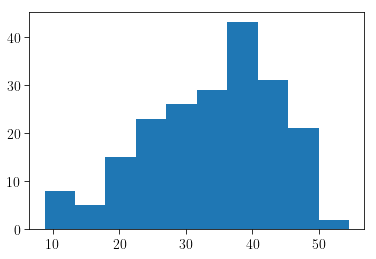

In [90]:
plt.hist(SpiceCore4ForInterp_limited.SNR_V)

In [91]:
SpiceCore4ForInterp_limited.loc[SpiceCore4ForInterp_limited.SNR_V>45]

,EvNum,Omega_reco,unixtime,SNR_V,SNR_H,theta_reco,interp_depth,Omega_true
465,25917,4.777442,1545790804,47.981704,4.242900,111.0,999.111111,15.024372
469,25968,11.570168,1545790812,49.601877,3.928952,111.0,997.333333,14.977422
472,26036,5.947770,1545790824,48.070874,0.561704,110.0,994.666667,14.906880
474,26096,1.832659,1545790834,51.538670,2.206999,112.0,992.444444,14.847987
478,26219,6.267014,1545790850,47.178836,1.782373,111.0,988.888889,14.753552
482,26329,7.635089,1545790865,47.662263,3.441393,111.0,985.555556,14.664786
488,26423,4.886565,1545790880,54.507740,3.093939,110.0,982.222222,14.575793
490,26440,3.315882,1545790883,49.750731,3.547838,111.0,981.555556,14.557967
494,26514,11.653267,1545790892,48.113841,3.980161,110.0,979.555556,14.504434
499,26626,8.849484,1545790911,46.166945,3.144814,111.0,975.333333,14.391143
